Нейросети оптимизируют свои веса, минимизируя средние потери по обучающей выборке:

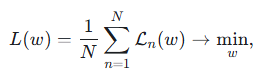

Поскольку нейросети представляют собой сложную суперпозицию нелинейных преобразований, то минимизация $L(w)$ не будет допускать аналитического решения и будет решаться **градиентными методами**.


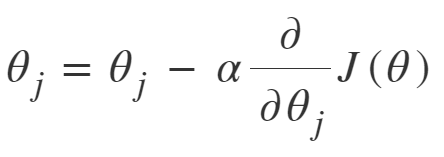

### Batch GD vs SGD vs Mini-Batch GD

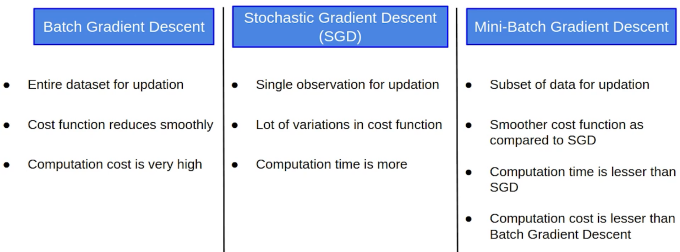

Немного фактов об этой троице:

- У GD есть проблема: он может застревать в локальных минимумах
- И для GD и для SGD нет гарантий глобального минимума, сходимости
- SGD быстрее,на каждой итерации используется только одно наблюдение
- Для SGD спуск очень зашумлён
- Шум в оценке градиента в SGD помогает выпрыгивать из локальных оптимумов
- Mini-batch GD за счёт векторизации также эффективен, как шаг по одному объекту
- Базово во всех алгоритмах применяется и тот же learning rate ко всем параметрам, что не всегда разумно. Параметр, "отвечающий" редкому классу, будет обучаться медленнее остальных.
- Если функция ошибки в одном направлении меняется быстро, а в другом — медленно, то это приводит к резким изменениям направления градиентов и замедляет процесс обучения.

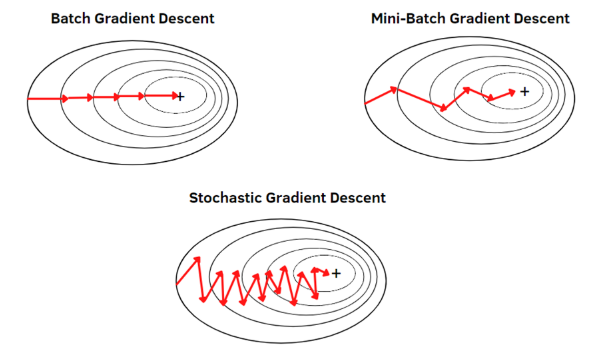

Mini-batch GD до сих пор является достаточно популярным методом обучения нейросетей, потому что он простой, не требует подбора дополнительных гиперпараметров, кроме скорости обучения lr, и сам по себе обычно дает неплохие результаты.



```python
class SGD:
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr

  def step(self):
    d_parameters = self.parameters.grad
    self.parameters -= self.lr*d_parameters
```



#### Выбор размера батча

[REVISITING SMALL BATCH TRAINING FOR DEEP NEURAL NETWORKS](https://arxiv.org/pdf/1804.07612)

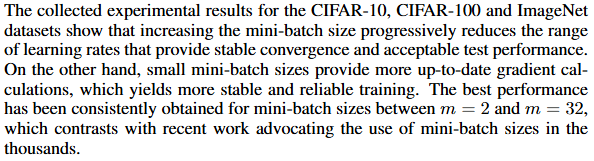

И еще

[DON’T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE](https://arxiv.org/pdf/1711.00489/)


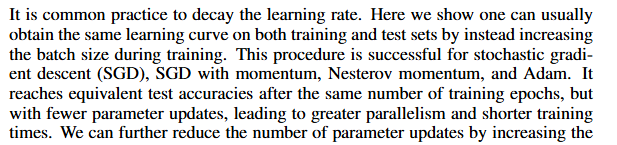

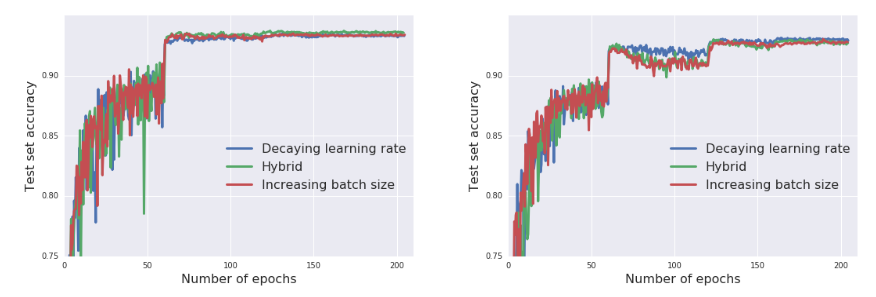

#### Выбор Learning Rate

Для mini-batch GD скорость обучения 𝜂 надо подбирать аккуратно: если она будет
большой, мы можем скакать вокруг минимума, если маленькой - вечно
ползти к нему

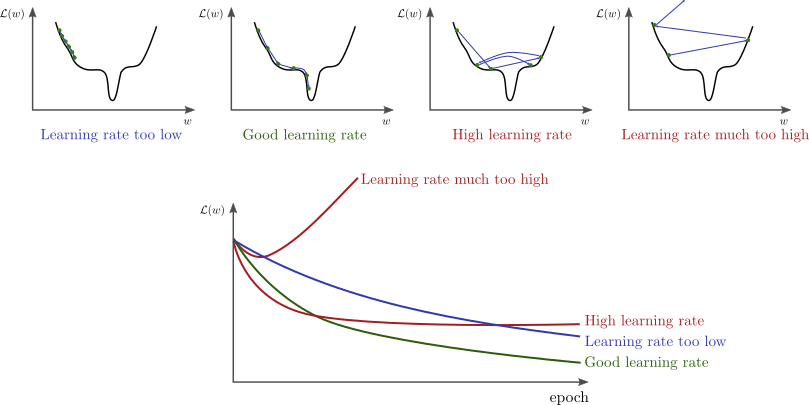

Для выбора шага обучения нужно отображать зависимость $L(w)$ от номера итерации. Потери должны убывать и не слишком медленно. Если потери растут, это свидетельствует о расходимости, и необходимо уменьшить 𝜂

### Momentum SGD

Чтобы избежать проблем с застреванием в локальных минимумах и чувствительностью к резким изменениям, можно добавить движению по ландшафту функции ошибок инерцию (*momentum*).

По аналогии с реальной жизнью: если мяч катится с горки, то он благодаря инерции может проскочить пологое место или даже небольшую яму.

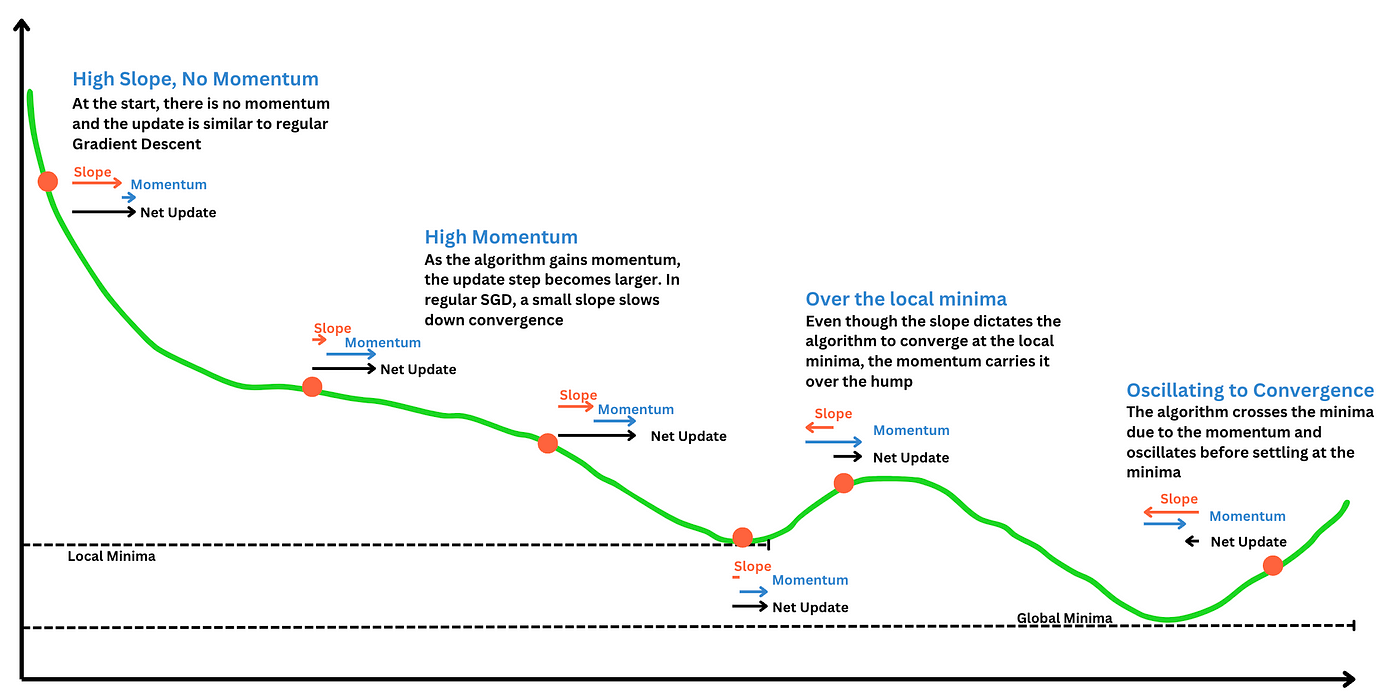

Корректируем направление движения шарика с учетом текущего градиента:

$$\large v_{t} = m \cdot v_{t-1} + \nabla_wL(x, y, w_{t}),$$

где $m \in [0, 1)$ — momentum (гиперпараметр).

Вычисляем, куда он покатится:

$$\large w_{t+1} = w_t - \text{lr} \cdot v_{t}$$

[Why Momentum Really Works](https://distill.pub/2017/momentum/)

Теперь мы быстрее достигаем локального минимума и можем выкатываться из совсем неглубоких. Градиент стал менее подвержен шуму, меньше осциллирует.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"> <img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/stohastic_gradient_descent_with_momentum.gif" width="500">

```python
class SGD_with_momentum:
  def __init__(self, parameters, momentum, lr):
    self.parameters = parameters
    self.momentum = momentum
    self.lr = lr
    self.velocity = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.velocity =  self.momentum*self.velocity + d_parameters
    self.weights -= self.lr*self.velocity
```


**Momentum удваивает количество хранимых параметров - почему?**

SGD и Momentum есть в PyTorch: [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

### NAG (Nesterov momentum)

Будем сначала смещаться в сторону, куда привел бы нас накопленный градиент, там считать новый градиент и смещаться по нему.
В результате перескоки через минимум будут менее значительными и алгоритм будет быстрее сходиться:

$$\large v_{t} = m \cdot v_{t-1} +  \nabla_w L(w_t - \text{lr} \cdot m \cdot  v_{t-1} )$$

$$\large w_{t+1} = w_{t} - \text{lr} \cdot v_{t} $$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/nesterov_momentum.png" width="800"></center>

Так же, как momentum, Nesterov momentum удваивает количество хранимых параметров

### Adagrad

Описанные алгоритмы не борются с проблемой SGD: "мы применяем **один и тот же learning rate ко всем параметрам**, что не всегда разумно. Параметр, отвечающий редкому классу, будет обучаться медленнее остальных".

Для решения этой проблемы мы можем завести для каждого параметра **индивидуальный learning rate**, зависящий от того, как часто и как сильно изменяется этот параметр в процессе обучения.

Будем хранить для каждого параметра **сумму квадратов его градиентов** (запоминаем, как часто и как сильно он изменялся).

И будем вычитать из значений параметров градиент с коэффициентом, обратно пропорциональным корню из этой суммы $G_t$.

$$\large G_ t = \sum_{i=1}^t \nabla_w L(x,y,w_i)\odot\nabla_w L(x,y,w_i), $$

$$\large w_{t+1} = w_{t} -  \frac{\text{lr}}{\sqrt{G_t} + e} \odot \nabla_w L(x,y,w_{t}), $$

где $e$ — малая константа, чтобы не допускать деления на ноль, $\odot$ — поэлементное умножение.

В результате, если градиент у нашего веса часто большой, коэффициент будет уменьшаться.

Проблема заключается в том, что при такой формуле learning rate неминуемо в конце концов затухает (так как сумма квадратов не убывает).



```python
class AdaGrad:
  def __init__(self, parameters, lr=0.01):
     self.parameters = parameters
     self.lr = lr
     self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared += d_parameters*d_parameters
    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adagrad удваивает количество хранимых параметров.**

[torch.optim.Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

### RMSprop

Добавим "забывание" предыдущих квадратов градиентов. Теперь мы считаем не сумму квадратов, а [экспоненциальное скользящее среднее](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F) с коэффициентом $\alpha$.


$$\large G_t = \alpha \cdot G_{t-1} + (1-\alpha) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t)$$

$$\large w_{t+1} = w_{t} - \frac{\text{lr}}{\sqrt{G_t }+ e} \odot \nabla_w L(x,y,w_t)$$


```python
class RMSprop():
  def __init__(self, parameters, lr=0.01, alpha=0.99):
    self.parameters = parameters
    self.lr = lr
    self.alpha = alpha
    self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared = self.alpha*self.grad_squared + \
        (1 - self.alpha)*d_parameters*d_parameters

    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Так же, как Adagrad, RMSprop удваивает количество хранимых параметров.**

[torch.optim.RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)

### Adam

Одним из самых популярных адаптивных оптимизаторов является Adam, объединяющий идеи Momentum и Adaptive learning rate:

$$\large v_t = \beta_1 \cdot v_{t-1} + (1-\beta_1) \cdot \nabla_w L(x,y,w_t),$$

$$\large G_t = \beta_2 \cdot G_{t-1} + (1-\beta_2) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t),$$

$$\large w_{t+1} = w_t - \frac{\text{lr}}{\sqrt{G_t} + e} \odot v_t,$$

где $\beta_1$ — аналог $m$ из Momentum, а $\beta_2$ — аналог $\alpha$ из RMSprop.


```python
class Adam:
  def __init__(self, parameters, lr=0.01, betas=(0.9, 0.999)):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.grad_squared = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum
    self.beta_2 = betas[1] # alpha

  def step(self):
    d_parameters = self.parameters.grad
    # Momentum
    self.velocity = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # Adaptive learning rate
    self.grad_squared = self.beta_2*self.grad_squared + \
        (1 - self.beta_2)*d_parameters*d_parameters
    self.parameters -= self.lr*self.velocity / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adam утраивает количество хранимых параметров.**

Чтобы в начале у нас получались очень большие шаги, будем дополнительно модицифировать инерцию и сумму квадратов:

$$\large v_t = \frac{v_t}{1-\beta_1^t}, \qquad G_t = \frac{G_t}{1-\beta_2^t} $$

[torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

### L2 vs Weight decay

Для использования L2 c оптимизатором необходимо указать значение `weight_decay`,  где `weight_decay` — коэффициент перед L2.

Вообще говоря, Weight decay и L2 — это **немного разные** вещи.

L2 добавляет член регуляризации к Loss функции:

$$\text{Loss}_{L2} = \text{Loss} + \frac{λ}{2n}w^2$$

Weight decay уменьшает веса:

$$w_{wd} = w - \frac{λ}{n}w$$

где $λ$ — константа, а $n$ — количество элементов в батче.


Для SGD оптимизатора Weight decay и L2 **эквивалентны**, но не для всех оптимизаторов это так.

Например, это не так для Adam. L2-регуляризация прибавляется к Loss функции и изменяет значение градиента, квадраты которого будут храниться. Weight decay изменяет только веса. Подробно об этом можно почитать в: [DECOUPLED WEIGHT DECAY REGULARIZATION](https://arxiv.org/pdf/1711.05101.pdf)

**Обратите внимание**, что `weight_decay` в `torch.optim.Adam` — это **коэффициент перед L2**. **Weight decay** для **Adam** реализовано в
`torch.optim.AdamW`.


### Еще больше оптимизаторов

[Stochastic Optimization](https://paperswithcode.com/methods/category/stochastic-optimization)

### Сравнение оптимизаторов

У каждого из предложенных оптимизаторов есть минусы и плюсы:

* Методы с инерцией сходятся к решению более плавно, но могут "перелетать".
* Методы с адаптивным learning rate быстрее сходятся, более стабильны и меньше случайно блуждают.
* Алгоритмы без адаптивного learning rate сложнее выбираются из локальных минимумов.
* Алгоритмы с инерцией осцилируют в седловых точках прежде, чем находят верный путь.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/methods_without_adaptive_learning_rate.gif" width="450"><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/methods_with_momentum_in_saddle_point.gif" width="450">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em></center>

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [ ]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data',
                            train = True,
                            download = True,
                            transform = train_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.42MB/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



In [ ]:
batch_size = 32

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train_epoch(iterator, model, optimizer, criterion, device):
    """Performs one epoch of training."""

    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

In [ ]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=5):
    """Trains the model for the given amount of epochs."""

    losses = []

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

In [ ]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [ ]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5), alpha=1.0):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label, alpha=alpha)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

#### Mini-batch SGD

100%|██████████| 1875/1875 [00:27<00:00, 69.32it/s]


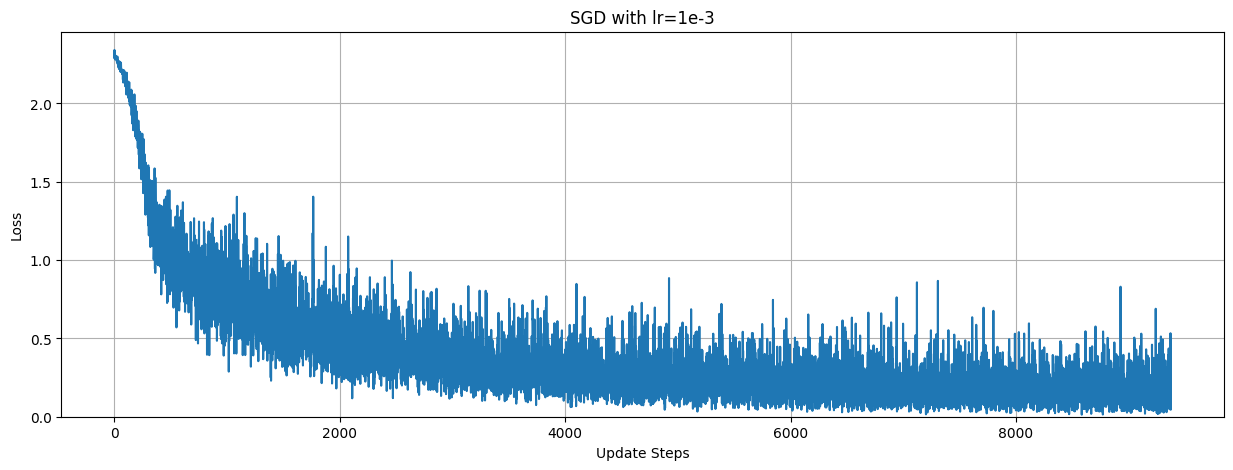

In [ ]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=0.01)

sgd_loss = train(train_iterator, model, optimizer, criterion, device)
plot_loss(sgd_loss, 'SGD with lr=1e-3')

#### Momentum SGD

100%|██████████| 1875/1875 [00:27<00:00, 68.12it/s]


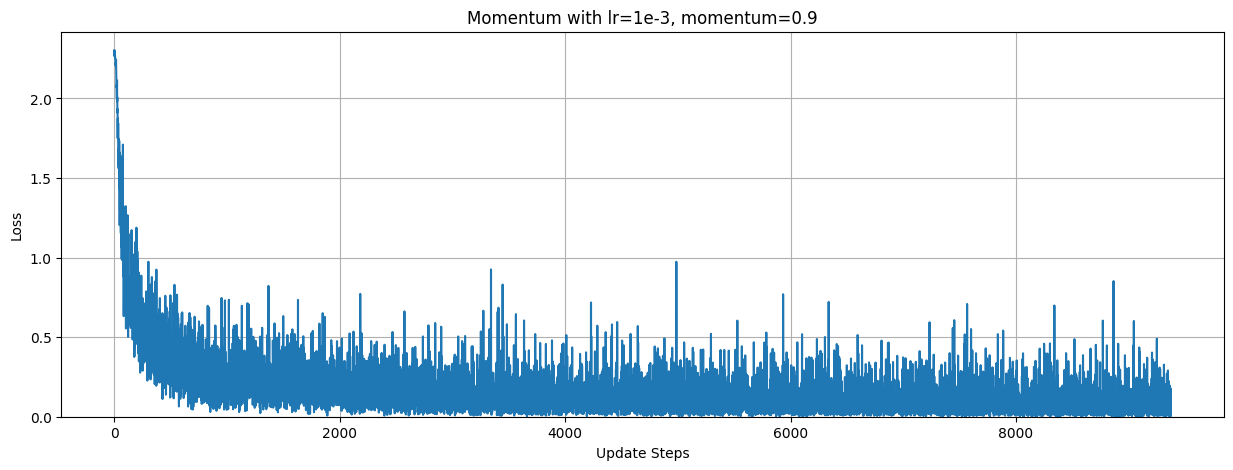

In [ ]:
from torch.optim import SGD # тот же класс!

model = MLP(input_dim, hid_dim, output_dim)
model = model.to(device)

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

momentum_loss = train(train_iterator, model, optimizer, criterion, device)
plot_loss(momentum_loss, 'Momentum with lr=1e-3, momentum=0.9')

#### NAG (Nesterov momentum)

100%|██████████| 1875/1875 [00:27<00:00, 68.04it/s]


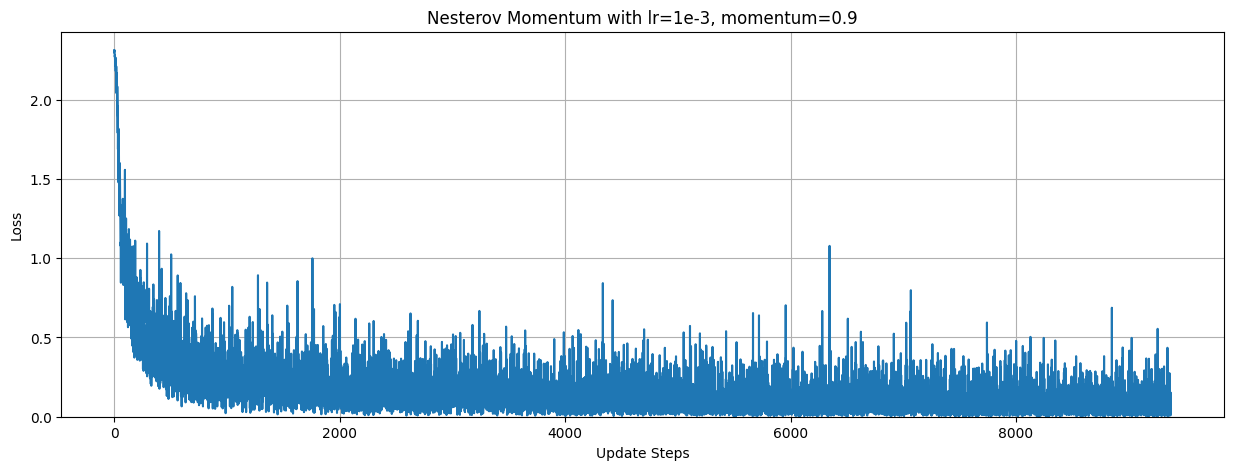

In [ ]:
from torch.optim import SGD # тот же класс!

model = MLP(input_dim, hid_dim, output_dim)
model = model.to(device)

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

nag_loss = train(train_iterator, model, optimizer, criterion, device)
plot_loss(nag_loss, 'Nesterov Momentum with lr=1e-3, momentum=0.9')

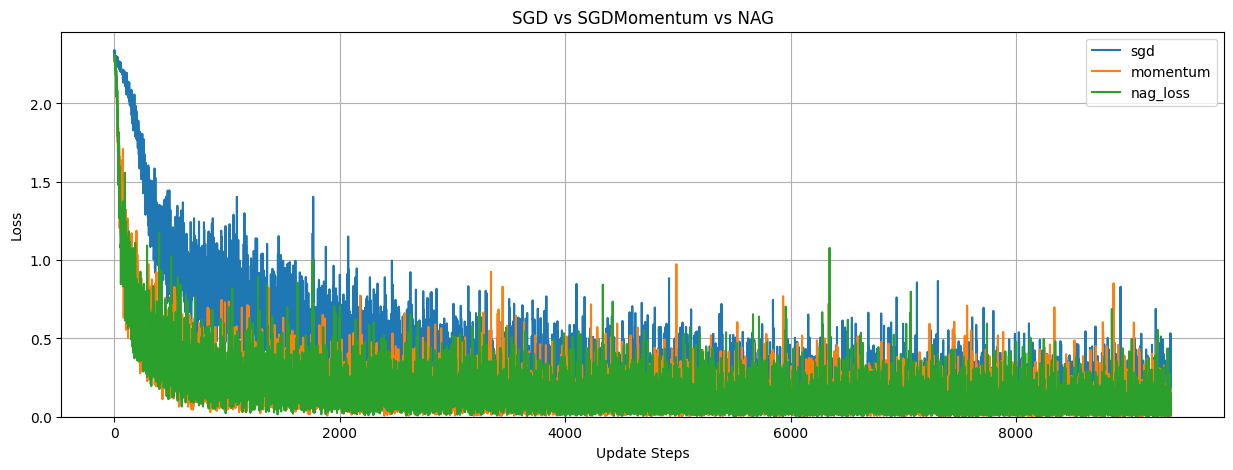

In [ ]:
losses = [sgd_loss, momentum_loss, nag_loss]
labels = ['sgd', 'momentum', 'nag_loss']

plot_losses(losses, labels, 'SGD vs SGDMomentum vs NAG')

#### Проверим остальные оптимизаторы

In [ ]:
from torch.optim import Adagrad, Adam, AdamW

losses = {}

for optim in [Adagrad, Adam, AdamW]:
  model = MLP(input_dim, hid_dim, output_dim)
  model = model.to(device)

  optimizer = optim(model.parameters())
  optimizer_name = optimizer.__class__.__name__

  print(f"Start training with optimizer {optimizer_name}")
  current_loss = train(train_iterator, model, optimizer, criterion, device)
  losses[optimizer_name] = current_loss

Start training with optimizer Adagrad


100%|██████████| 1875/1875 [00:28<00:00, 66.94it/s]


Start training with optimizer Adam


100%|██████████| 1875/1875 [00:28<00:00, 65.39it/s]


Start training with optimizer AdamW


100%|██████████| 1875/1875 [00:28<00:00, 66.43it/s]


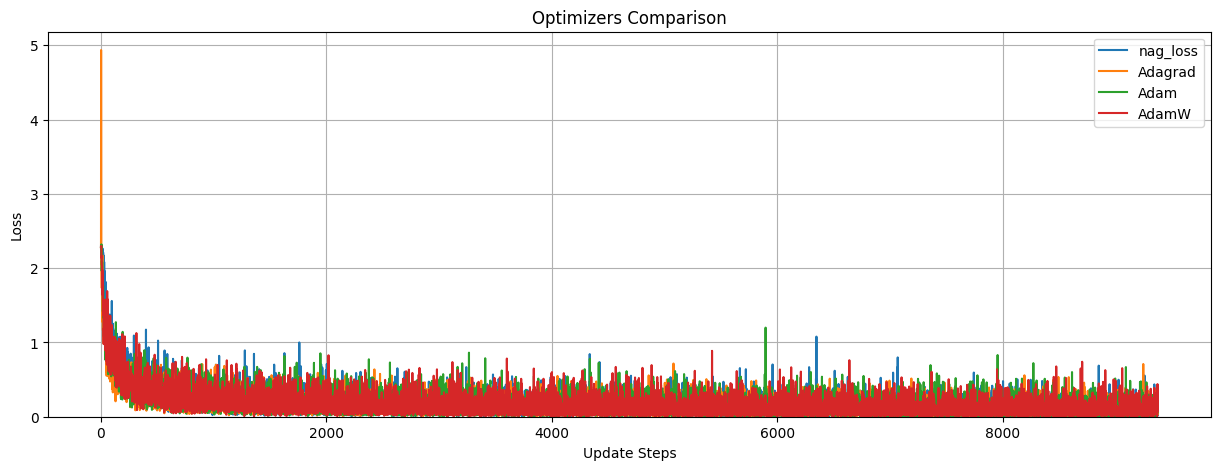

In [ ]:
all_losses = [nag_loss] + list(losses.values())
labels = ['nag_loss'] + list(losses.keys())
plot_losses(all_losses, labels, 'Optimizers Comparison')

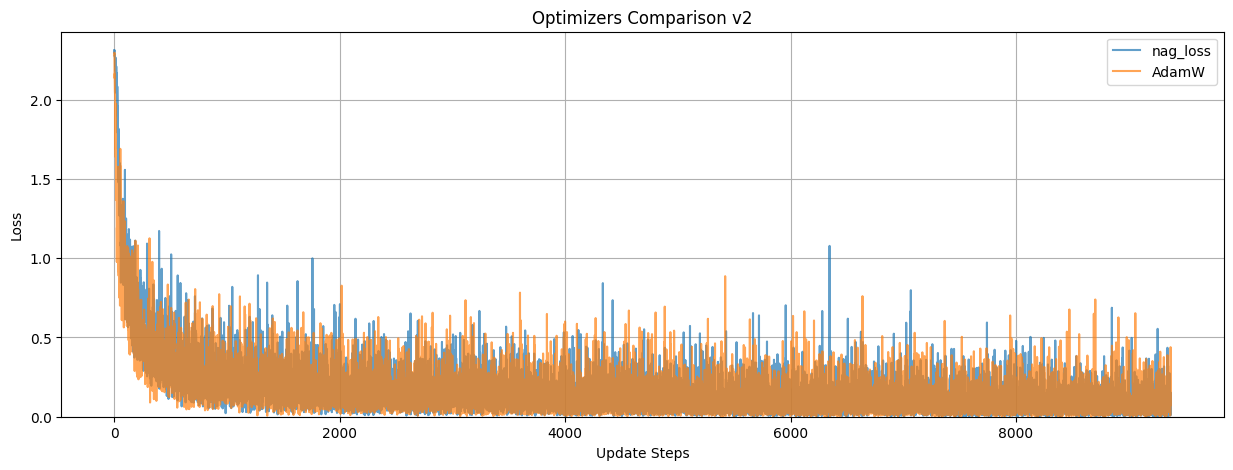

In [ ]:
all_losses = [nag_loss] + [losses['AdamW']]
labels = ['nag_loss', 'AdamW']
plot_losses(all_losses, labels, 'Optimizers Comparison v2', alpha=0.7)

[On Empirical Comparisons of Optimizers for Deep Learning](https://)

### Как выбрать оптимизатор?


- Какие оптимизаторы использовались в сходных задачах?
- Каковы ваши ограничения?

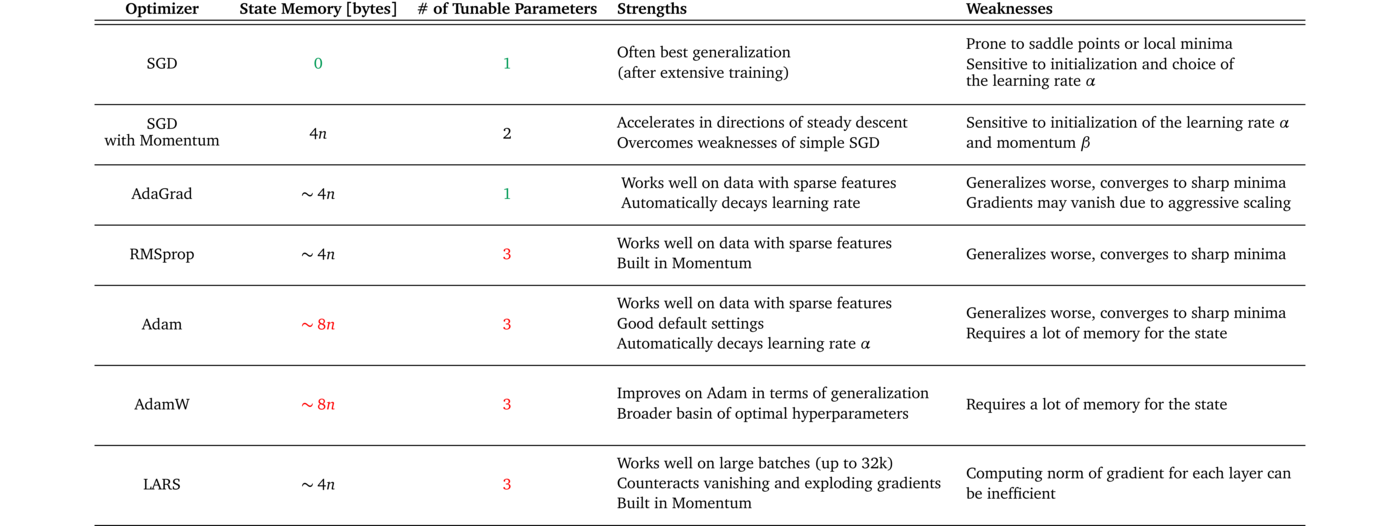